   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1   0.541262        1.0   0.470109   0.587131   0.984127   0.592593   
2   0.597087        1.0   0.532609   0.595174   0.761905   0.592593   
3   0.631068        1.0   0.570652   0.710456   0.444444   0.777778   
4   0.740291        0.0   0.692935   0.772118   0.587302   0.777778   
5   1.000000        0.0   1.000000   1.000000   0.587302   1.000000   

   var7(t-1)  var8(t-1)   var1(t)  
1   0.816667   0.119231  0.597087  
2   0.933333   0.126923  0.631068  
3   0.816667   0.200000  0.740291  
4   0.941667   0.200000  1.000000  
5   0.766667   0.046154  0.711165  
****************************************************************************************************
(1161, 1, 8) (1161,) (17, 1, 8) (17,)
Train on 1161 samples, validate on 17 samples
Epoch 1/50
 - 1s - loss: 0.1010 - val_loss: 0.0806
Epoch 2/50
 - 0s - loss: 0.0451 - val_loss: 0.0696
Epoch 3/50
 - 0s - loss: 0.0391 - val_loss: 0.0768
Epoch 4/50
 - 0s - 

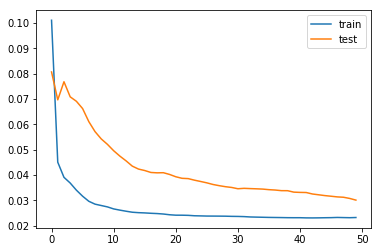

[124.        62.999996  95.       142.       151.       120.00001
  47.        86.       115.00001  122.        81.        91.
  73.        48.        83.       189.       164.      ]
****************************************************************************************************
[128.43471   78.91019   87.61666  122.931694 118.48776  108.501015
  52.229378  81.81052  104.6149   105.876205  91.5505    87.078445
  71.080864  54.67422   85.248505 150.58984  143.3136  ]
Test RMSE: 16.044
****************************************************************************************************
[ 91.88676   75.53938   58.131847  61.284725  53.97619   56.2113
 111.49199   64.1171    73.05882   65.19625  110.608826]


In [2]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import tensorflow as tf
import pandas as pd

# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
dataset = read_csv('苏州.csv', header=0, index_col=0)
values = dataset.values

# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
#print(reframed)
#print('*'*100)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

print('*'*100)

# split into train and test sets
values = reframed.values

n = list()
for i in range(89,303):
    n.append(i)
for i in range(449,663):
    n.append(i)
for i in range(815,1029):
    n.append(i)
for i in range(1180,1394):
    n.append(i)
for i in range(1545,1759):
    n.append(i)
for i in range(1910,2001):
    n.append(i)

#print(n)

#取3，4，5，6，7，8，9月份数据为训练集
train = values[n, :]
#取2019年6月份数据为测试集
test = values[2001:, :]

#n_train_hours = 1970
#train = values[:n_train_hours, :]
#test = values[n_train_hours:, :]

# split into input and outputs
train_X, train_y = train[:, 1:], train[:, 0]
test_X, test_y = test[:, 1:], test[:, 0]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

model.save('air_analysis.model')

# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

#打印真实AQI
print(inv_y)
print('*'*100)
#打印预测AQI
print(inv_yhat)

# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

model = tf.keras.models.load_model('air_analysis.model')
 
dataset = pd.read_csv('forecast.csv', header=0, index_col=0)
    
# 数据预处理：
values = dataset.values
# LabelEncoder是对不连续的数字或文本编号。
encoder = LabelEncoder()
values[:, 1] = encoder.fit_transform(values[:, 1])
# ensure all data is float
values = values.astype('float32')
# 数据归一化：此时已经去掉时间值，第一列为污染指数PM2.5:
scaler = MinMaxScaler(feature_range=(0, 1))
values = scaler.fit_transform(values)
train_X = values.reshape((values.shape[0], 1, values.shape[1]))
# 数据预测：
yhat = model.predict(train_X)
# 数据还原：
test_X = train_X.reshape((train_X.shape[0], train_X.shape[2]))
# invert scaling for forecast concatenate：数据拼接
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
# 3、是将标准化后的数据转换为原始数据：
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:, 0]

print('*'*100)
print(inv_yhat)